In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Ensure reproducibility
RANDOM_SEED = 123
def seed_torch(seed=RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [2]:
def gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5):
    """
    Calculate the gravity law-based commute distance between two locations.
    
    Args:
        lat1, lng1: Latitude and longitude of the first location.
        pop1: Population of the first location.
        lat2, lng2: Latitude and longitude of the second location.
        pop2: Population of the second location.
        r: Distance decay parameter.
    
    Returns:
        A float representing the gravity-based commute distance.
    """
    # Calculate Euclidean distance
    distance = math.sqrt((lat1 - lat2)**2 + (lng1 - lng2)**2)
    # Gravity law: interaction strength decreases with distance and increases with population
    gravity_dist = (pop1 * pop2) / (distance ** r + 1e-5)  # Added epsilon to avoid division by zero
    return gravity_dist


In [3]:
# Mocking GenerateTrainingData for demonstration purposes
class GenerateTrainingData:
    @staticmethod
    def download_jhu_data(start_date, end_date):
        """
        Downloads and preprocesses JHU COVID-19 data between start_date and end_date.
        
        Args:
            start_date (str): Start date in 'YYYY-MM-DD' format.
            end_date (str): End date in 'YYYY-MM-DD' format.
        
        Returns:
            A pandas DataFrame containing the filtered COVID-19 data.
        """
        # For demonstration, load a pre-saved pickle file
        # Replace this with actual data download and preprocessing as needed
        raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
        # Filter data between start_date and end_date
        mask = (raw_data['date_today'] >= start_date) & (raw_data['date_today'] <= end_date)
        filtered_data = raw_data.loc[mask].reset_index(drop=True)
        return filtered_data

# Download and load COVID-19 data
raw_data = GenerateTrainingData.download_jhu_data('2020-05-01', '2021-12-01')
print(f"COVID-19 Data Shape: {raw_data.shape}")
raw_data.head()


COVID-19 Data Shape: (12354, 11)


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,7977,290,0.0,7687.0,12.0,277
1,Alabama,32.3182,-86.9023,1.0,2020-05-04,8203,298,0.0,7905.0,29.0,226
2,Alabama,32.3182,-86.9023,1.0,2020-05-05,8520,315,391.0,198.0,43.0,317
3,Alabama,32.3182,-86.9023,1.0,2020-05-06,8769,343,405.0,192.0,51.0,249
4,Alabama,32.3182,-86.9023,1.0,2020-05-07,9115,369,409.0,215.0,20.0,346


In [4]:
# Load population data
pop_data = pd.read_csv('./uszips.csv')
print(f"Original Population Data Shape: {pop_data.shape}")
pop_data.head()


Original Population Data Shape: (33099, 18)


,zip,lat,lng,city,state,state_name,zcta,parent_zcta,population,density,county_fips,county,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18004,-66.75218,ADJUNTAS,PR,Puerto Rico,True,NaN,17242,111.4,72001,ADJUNTAS,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,AGUADA,PR,Puerto Rico,True,NaN,38442,523.5,72003,AGUADA,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,AGUADILLA,PR,Puerto Rico,True,NaN,48814,667.9,72005,AGUADILLA,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,MARICAO,PR,Puerto Rico,True,NaN,6437,60.4,72093,MARICAO,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,ANASCO,PR,Puerto Rico,True,NaN,27073,312.0,72011,ANASCO,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico


In [5]:
# Aggregate population data by state
pop_data = pop_data.groupby('state_name').agg({
    'population': 'sum',
    'density': 'mean',
    'lat': 'mean',
    'lng': 'mean'
}).reset_index()

print(f"Aggregated Population Data Shape: {pop_data.shape}")
pop_data.head()

Aggregated Population Data Shape: (52, 5)


,state_name,population,density,lat,lng
0,Alabama,4864630,139.010903,32.884042,-86.819800
1,Alaska,737979,88.192437,61.656278,-153.337221
2,Arizona,6949259,447.967160,33.705827,-111.575755
3,Arkansas,2990472,80.360237,35.134413,-92.377327
4,California,39140219,1257.655082,36.425895,-119.922270


In [6]:
# Merge COVID-19 data with population data
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')
print(f"Merged Data Shape: {raw_data.shape}")
raw_data.head()

Merged Data Shape: (11076, 16)


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases,state_name,population,density,lat,lng
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,7977,290,0.0,7687.0,12.0,277,Alabama,4864630,139.010903,32.884042,-86.8198
1,Alabama,32.3182,-86.9023,1.0,2020-05-04,8203,298,0.0,7905.0,29.0,226,Alabama,4864630,139.010903,32.884042,-86.8198
2,Alabama,32.3182,-86.9023,1.0,2020-05-05,8520,315,391.0,198.0,43.0,317,Alabama,4864630,139.010903,32.884042,-86.8198
3,Alabama,32.3182,-86.9023,1.0,2020-05-06,8769,343,405.0,192.0,51.0,249,Alabama,4864630,139.010903,32.884042,-86.8198
4,Alabama,32.3182,-86.9023,1.0,2020-05-07,9115,369,409.0,215.0,20.0,346,Alabama,4864630,139.010903,32.884042,-86.8198


In [7]:
# Generate location similarity based on Gravity Law
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state'] == each_loc]['lat'].unique()[0]
        lng1 = raw_data[raw_data['state'] == each_loc]['lng'].unique()[0]
        pop1 = raw_data[raw_data['state'] == each_loc]['population'].unique()[0]

        lat2 = raw_data[raw_data['state'] == each_loc2]['lat'].unique()[0]
        lng2 = raw_data[raw_data['state'] == each_loc2]['lng'].unique()[0]
        pop2 = raw_data[raw_data['state'] == each_loc2]['population'].unique()[0]

        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(
            lat1, lng1, pop1,
            lat2, lng2, pop2,
            r=0.5
        )

num_locations = len(loc_list)
print(f"Number of unique locations: {num_locations}")


Number of unique locations: 52


In [8]:
num_locations = len(loc_list)
print(f"Number of unique locations: {num_locations}")

Number of unique locations: 52


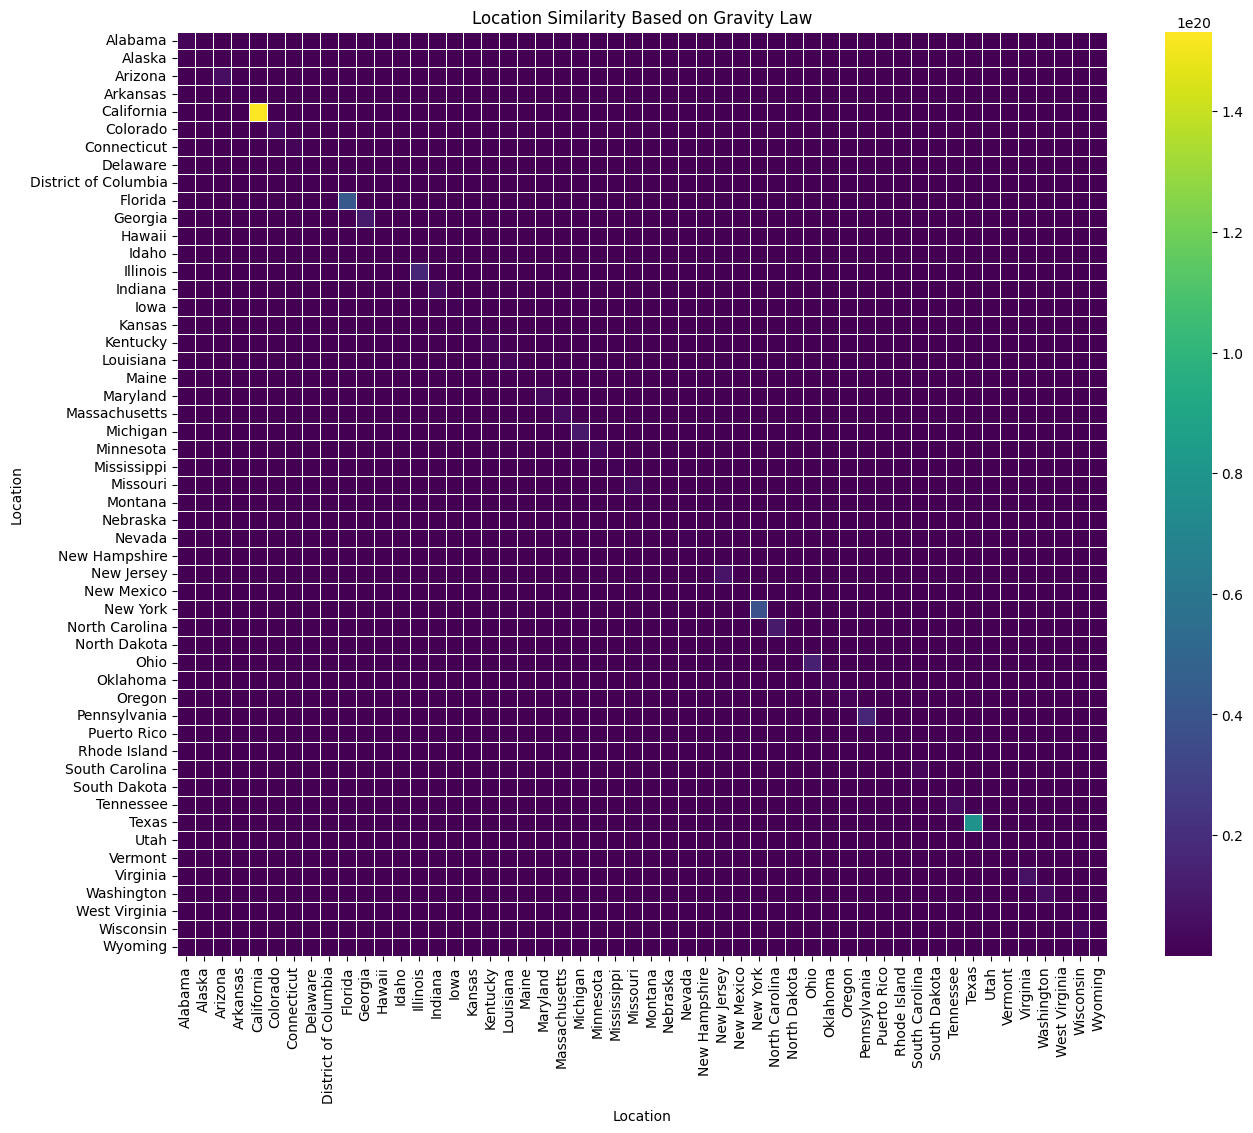

In [9]:
import seaborn as sns

# Convert loc_dist_map to a DataFrame for visualization
loc_dist_df = pd.DataFrame(loc_dist_map).fillna(0)

# Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(loc_dist_df, cmap='viridis', linewidths=.5)
plt.title('Location Similarity Based on Gravity Law')
plt.xlabel('Location')
plt.ylabel('Location')
plt.show()

In [10]:
# # Gather all similarity scores
# all_scores = [score for neighbors in loc_dist_map.values() for score in neighbors.values()]
# print(f"Number of similarity scores: {len(all_scores)}")

In [11]:
# # Define dynamic threshold using the 75th percentile
# dist_threshold = np.percentile(all_scores, 75)
# print(f"Distance Threshold: {dist_threshold}")

In [12]:
# # Sort each state's neighbors based on similarity scores in descending order
# for each_loc in loc_dist_map:
#     sorted_neighbors = sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)
#     loc_dist_map[each_loc] = sorted_neighbors

# # Create adjacency map: for each state, select top neighbors based on dynamic threshold
# adj_map = {}
# for each_loc in loc_dist_map:
#     adj_map[each_loc] = []
#     for i, (each_loc2, score) in enumerate(loc_dist_map[each_loc]):
#         if score > dist_threshold:
#             if i < 3:
#                 adj_map[each_loc].append(each_loc2)
#         else:
#             if i < 1:
#                 adj_map[each_loc].append(each_loc2)
#             else:
#                 break

# # Display adjacency map
# print("Adjacency Map:")
# for state, neighbors in adj_map.items():
#     print(f"{state}: {neighbors}")

In [13]:
# Define distance threshold
dist_threshold = 18  # Adjust based on data distribution

# Sort each state's neighbors based on similarity scores in descending order
for each_loc in loc_dist_map:
    # Sort neighbors by similarity score (descending)
    sorted_neighbors = sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)
    loc_dist_map[each_loc] = sorted_neighbors

# Create adjacency map: for each state, select top neighbors based on threshold
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, (each_loc2, score) in enumerate(loc_dist_map[each_loc]):
        if score > dist_threshold:
            if i < 3:  # Select top 3 neighbors above threshold
                adj_map[each_loc].append(each_loc2)
        else:
            if i < 1:  # Select top 1 neighbors below threshold
                adj_map[each_loc].append(each_loc2)
            else:
                break  # Stop if score is below threshold and limit reached

# Display adjacency map
print("Adjacency Map:")
for state, neighbors in adj_map.items():
    print(f"{state}: {neighbors}")


Adjacency Map:
Alabama: ['Alabama', 'Texas', 'Florida']
Alaska: ['Alaska', 'California', 'Texas']
Arizona: ['Arizona', 'California', 'Texas']
Arkansas: ['Arkansas', 'Texas', 'California']
California: ['California', 'Texas', 'Florida']
Colorado: ['Colorado', 'California', 'Texas']
Connecticut: ['Connecticut', 'New York', 'New Jersey']
Delaware: ['Delaware', 'New York', 'Pennsylvania']
District of Columbia: ['District of Columbia', 'Maryland', 'New York']
Florida: ['Florida', 'Texas', 'California']
Georgia: ['Georgia', 'Florida', 'Texas']
Hawaii: ['Hawaii', 'California', 'Texas']
Idaho: ['Idaho', 'California', 'Texas']
Illinois: ['Illinois', 'Texas', 'California']
Indiana: ['Indiana', 'Illinois', 'Texas']
Iowa: ['Iowa', 'Texas', 'California']
Kansas: ['Kansas', 'Texas', 'California']
Kentucky: ['Kentucky', 'Texas', 'California']
Louisiana: ['Louisiana', 'Texas', 'California']
Maine: ['Maine', 'New York', 'California']
Maryland: ['Maryland', 'New York', 'Pennsylvania']
Massachusetts: ['Ma

In [14]:
# Initialize adjacency matrix
num_states = len(loc_list)
adj_matrix = np.zeros((num_states, num_states), dtype=np.float32)

# Populate adjacency matrix based on adj_map
for i, each_loc in enumerate(loc_list):
    for each_loc2 in adj_map[each_loc]:
        j = list(loc_list).index(each_loc2)
        adj_matrix[i][j] = 1  # Binary adjacency; set to 1 if connected

# Convert adjacency matrix to tensor
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32).to(device)
print(f"Adjacency Matrix Shape: {adj_matrix.shape}")


Adjacency Matrix Shape: torch.Size([52, 52])


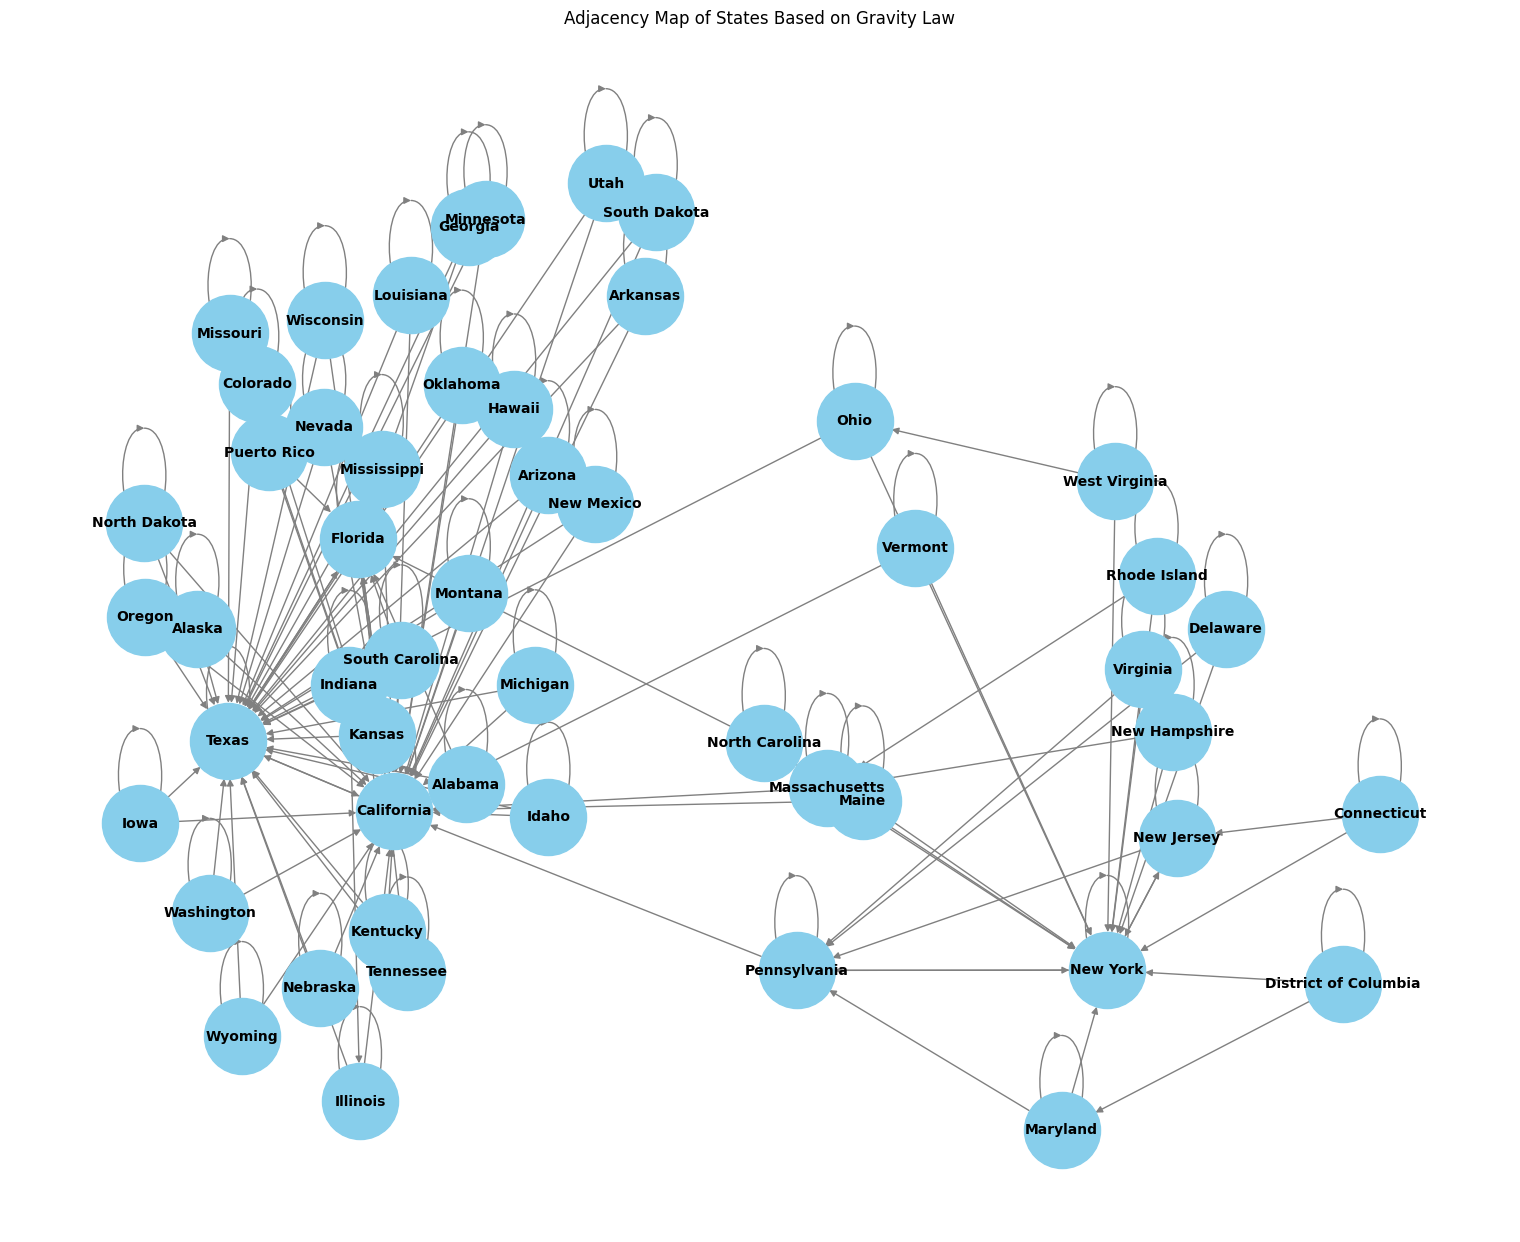

In [23]:
import networkx as nx
# Visualize the adjacency graph
G_nx = nx.DiGraph()
# Add nodes
for state in adj_map.keys():
    G_nx.add_node(state)

# Add edges
for state, neighbors in adj_map.items():
    for neighbor in neighbors:
        G_nx.add_edge(state, neighbor)

# Plot the adjacency graph
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G_nx, seed=RANDOM_SEED)  # For consistent layout
nx.draw(
    G_nx,
    pos,
    with_labels=True,
    node_size=3000,
    node_color='skyblue',
    font_size=10,
    font_weight='bold',
    edge_color='gray'
)
plt.title('Adjacency Map of States Based on Gravity Law')
plt.show()

In [15]:
# Add self-loops to the adjacency matrix
adj_matrix += torch.eye(num_states).to(device)

# Normalize adjacency matrix
adj_matrix = adj_matrix / adj_matrix.sum(dim=1, keepdim=True)

print("Adjacency Matrix with Self-Loops and Normalized:")
print(adj_matrix)


Adjacency Matrix with Self-Loops and Normalized:
tensor([[0.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5000]],
       device='cuda:0')


In [16]:
# Select relevant columns
dynamic_features = ['confirmed', 'deaths', 'recovered', 'active', 'hospitalization', 'new_cases']
static_features = ['population', 'density', 'lat', 'lng']

# Sort data by state and date
raw_data = raw_data.sort_values(['state', 'date_today']).reset_index(drop=True)

# Verify the data
print(raw_data[['state', 'date_today'] + dynamic_features + static_features].head())




     state date_today  confirmed  deaths  recovered  active  hospitalization  \
0  Alabama 2020-05-03       7977     290        0.0  7687.0             12.0   
1  Alabama 2020-05-04       8203     298        0.0  7905.0             29.0   
2  Alabama 2020-05-05       8520     315      391.0   198.0             43.0   
3  Alabama 2020-05-06       8769     343      405.0   192.0             51.0   
4  Alabama 2020-05-07       9115     369      409.0   215.0             20.0   

   new_cases  population     density        lat      lng  
0        277     4864630  139.010903  32.884042 -86.8198  
1        226     4864630  139.010903  32.884042 -86.8198  
2        317     4864630  139.010903  32.884042 -86.8198  
3        249     4864630  139.010903  32.884042 -86.8198  
4        346     4864630  139.010903  32.884042 -86.8198  


In [17]:
# Initialize scalers
dynamic_scaler = MinMaxScaler()
static_scaler = MinMaxScaler()

# Fit scalers on the entire dataset
raw_data[dynamic_features] = dynamic_scaler.fit_transform(raw_data[dynamic_features])
raw_data[static_features] = static_scaler.fit_transform(raw_data[static_features])

print("Data after normalization:")
raw_data.head()


Data after normalization:


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases,state_name,population,density,lat,lng
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,0.005933,0.008201,0.000000,0.014152,0.000752,0.008764,Alabama,0.111067,0.025381,0.336753,0.774807
1,Alabama,32.3182,-86.9023,1.0,2020-05-04,0.006110,0.008433,0.000000,0.014553,0.001818,0.007151,Alabama,0.111067,0.025381,0.336753,0.774807
2,Alabama,32.3182,-86.9023,1.0,2020-05-05,0.006357,0.008926,0.000400,0.000365,0.002695,0.010030,Alabama,0.111067,0.025381,0.336753,0.774807
3,Alabama,32.3182,-86.9023,1.0,2020-05-06,0.006551,0.009737,0.000415,0.000353,0.003197,0.007879,Alabama,0.111067,0.025381,0.336753,0.774807
4,Alabama,32.3182,-86.9023,1.0,2020-05-07,0.006821,0.010491,0.000419,0.000396,0.001254,0.010948,Alabama,0.111067,0.025381,0.336753,0.774807


In [18]:
def generate_series(data, window_size=35, pred_size=28):
    """
    Generates time-series sequences for modeling.
    
    Args:
        data (pd.DataFrame): The preprocessed data.
        window_size (int): Number of past days to consider.
        pred_size (int): Number of future days to predict.
    
    Returns:
        Tuple of (X, y) where:
            X: [num_samples, window_size, num_features]
            y: [num_samples, pred_size]
    """
    X = []
    y = []
    states = data['state'].unique()
    
    for state in states:
        state_data = data[data['state'] == state].reset_index(drop=True)
        total_days = len(state_data)
        for i in range(total_days - window_size - pred_size + 1):
            X.append(state_data.loc[i:i+window_size-1, dynamic_features + static_features].values)
            y.append(state_data.loc[i+window_size:i+window_size+pred_size-1, 'hospitalization'].values)
    
    X = np.array(X)  # [num_samples, window_size, num_features]
    y = np.array(y)  # [num_samples, pred_size]
    return X, y

# Generate sequences
window_size = 35
pred_size = 28
X, y = generate_series(raw_data, window_size=window_size, pred_size=pred_size)

print(f"Generated Sequences - X shape: {X.shape}, y shape: {y.shape}")


Generated Sequences - X shape: (7852, 35, 10), y shape: (7852, 28)


In [19]:
from sklearn.model_selection import train_test_split

def temporal_split(X, y, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    """
    Splits the data into training, validation, and test sets based on temporal ordering.
    
    Args:
        X (np.ndarray): Input features.
        y (np.ndarray): Targets.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.
    
    Returns:
        Tuple: (train_X, val_X, test_X, train_y, val_y, test_y)
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."
    total_samples = X.shape[0]
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)
    
    train_X = X[:train_end]
    val_X = X[train_end:val_end]
    test_X = X[val_end:]
    
    train_y = y[:train_end]
    val_y = y[train_end:val_end]
    test_y = y[val_end:]
    
    return train_X, val_X, test_X, train_y, val_y, test_y

# Split the data
train_X, val_X, test_X, train_y, val_y, test_y = temporal_split(X, y, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

print(f"Training Set: X={train_X.shape}, y={train_y.shape}")
print(f"Validation Set: X={val_X.shape}, y={val_y.shape}")
print(f"Test Set: X={test_X.shape}, y={test_y.shape}")


Training Set: X=(4711, 35, 10), y=(4711, 28)
Validation Set: X=(1570, 35, 10), y=(1570, 28)
Test Set: X=(1571, 35, 10), y=(1571, 28)


In [20]:
class HOIST_with_static(nn.Module):
    def __init__(self, dynamic_dims, static_dim, rnn_dim, device):
        super(HOIST_with_static, self).__init__()
        self.dynamic_dims = dynamic_dims
        self.static_dim = static_dim
        self.device = device
        self.rnn_dim = rnn_dim
        
        # Define dynamic feature weight networks
        self.covid_weight = nn.Sequential(
            nn.Linear(1, rnn_dim),
            nn.LeakyReLU(),
            nn.Linear(rnn_dim, 1),
            nn.Sigmoid()
        )
        self.claim_weight = nn.Sequential(
            nn.Linear(20, rnn_dim),
            nn.LeakyReLU(),
            nn.Linear(rnn_dim, 20),
            nn.Sigmoid()
        )
        self.hos_weight = nn.Sequential(
            nn.Linear(4, rnn_dim),
            nn.LeakyReLU(),
            nn.Linear(rnn_dim, 4),
            nn.Sigmoid()
        )
        self.vac_weight = nn.Sequential(
            nn.Linear(17, rnn_dim),
            nn.LeakyReLU(),
            nn.Linear(rnn_dim, 17),
            nn.Sigmoid()
        )
        
        # Define LSTM
        self.rnn = nn.LSTM(dynamic_dims, rnn_dim, batch_first=True)
        
        # Define static feature transformation
        self.static_fc = nn.Sequential(
            nn.Linear(static_dim, rnn_dim),
            nn.LeakyReLU()
        )
        
        # Define fully connected layers
        self.linear = nn.Linear(rnn_dim, rnn_dim)
        self.linear_2 = nn.Linear(rnn_dim, 1)
        
        # Define static feature embeddings and attention parameters
        # Assuming static_dim is a tuple: (pop_dim, demo_dim, eco_dim)
        pop_dim, demo_dim, eco_dim = static_dim
        self.W_pop = nn.Parameter(
            nn.init.xavier_normal_(torch.Tensor(pop_dim, pop_dim), gain=np.sqrt(2.0)),
            requires_grad=True
        ).to(device)
        self.a_pop = nn.Parameter(
            nn.init.xavier_normal_(torch.Tensor(2 * pop_dim, 1), gain=np.sqrt(2.0)),
            requires_grad=True
        ).to(device)
        self.W_demo = nn.Parameter(
            nn.init.xavier_normal_(torch.Tensor(demo_dim, demo_dim), gain=np.sqrt(2.0)),
            requires_grad=True
        ).to(device)
        self.a_demo = nn.Parameter(
            nn.init.xavier_normal_(torch.Tensor(2 * demo_dim, 1), gain=np.sqrt(2.0)),
            requires_grad=True
        ).to(device)
        self.W_eco = nn.Parameter(
            nn.init.xavier_normal_(torch.Tensor(eco_dim, eco_dim), gain=np.sqrt(2.0)),
            requires_grad=True
        ).to(device)
        self.a_eco = nn.Parameter(
            nn.init.xavier_normal_(torch.Tensor(2 * eco_dim, 1), gain=np.sqrt(2.0)),
            requires_grad=True
        ).to(device)
        self.W_geo = nn.Parameter(
            nn.init.xavier_normal_(torch.Tensor(2, 2), gain=np.sqrt(2.0)),
            requires_grad=True
        ).to(device)
        self.a_geo = nn.Parameter(
            nn.init.xavier_normal_(torch.Tensor(2, 1), gain=np.sqrt(2.0)),
            requires_grad=True
        ).to(device)
    
    def forward(self, dynamic, static, distance=None, h0=None):
        pop, demo, eco, geo = static
        N = pop.shape[0]
        T = dynamic.shape[1]
        
        # Process static features for attention
        h_pop = torch.mm(pop, self.W_pop)  # [N, pop_dim]
        h_pop = torch.cat([
            h_pop.unsqueeze(1).repeat(1, N, 1),
            h_pop.unsqueeze(0).repeat(N, 1, 1)
        ], dim=2)  # [N, N, 2 * pop_dim]
        d_pop = torch.sigmoid(h_pop @ self.a_pop).reshape(N, N)  # [N, N]
        
        h_demo = torch.mm(demo, self.W_demo)  # [N, demo_dim]
        h_demo = torch.cat([
            h_demo.unsqueeze(1).repeat(1, N, 1),
            h_demo.unsqueeze(0).repeat(N, 1, 1)
        ], dim=2)  # [N, N, 2 * demo_dim]
        d_demo = torch.sigmoid(h_demo @ self.a_demo).reshape(N, N)  # [N, N]
        
        h_eco = torch.mm(eco, self.W_eco)  # [N, eco_dim]
        h_eco = torch.cat([
            h_eco.unsqueeze(1).repeat(1, N, 1),
            h_eco.unsqueeze(0).repeat(N, 1, 1)
        ], dim=2)  # [N, N, 2 * eco_dim]
        d_eco = torch.sigmoid(h_eco @ self.a_eco).reshape(N, N)  # [N, N]
        
        h_geo = geo @ self.W_geo  # [N, 2]
        d_geo = torch.sigmoid(h_geo @ self.a_geo).reshape(N, N)  # [N, N]
        
        # Aggregate attention weights
        dist = d_pop + d_demo + d_eco + d_geo  # [N, N]
        dist = torch.softmax(dist, dim=-1)  # [N, N]
        
        # Apply dynamic feature weights
        cov_weights = self.covid_weight(dynamic[:, :, 0].unsqueeze(-1).reshape(N * T, 1)).reshape(N, T, 1)
        claim_weights = self.claim_weight(dynamic[:, :, 1:21].reshape(N * T, 20)).reshape(N, T, 20)
        hos_weights = self.hos_weight(dynamic[:, :, 21:25].reshape(N * T, 4)).reshape(N, T, 4)
        vac_weights = self.vac_weight(dynamic[:, :, 25:42].reshape(N * T, 17)).reshape(N, T, 17)
        
        # Combine weights (vaccination weights are negated based on the model's design)
        total_weights = torch.cat([cov_weights, claim_weights, hos_weights, -vac_weights], dim=-1)  # [N, T, sum(D_k)]
        
        # Initialize hidden state if not provided
        if h0 is None:
            h0 = torch.randn(1, N, self.rnn_dim).to(self.device)
        
        # Element-wise multiplication of weights and dynamic features
        weighted_dynamic = total_weights * dynamic  # [N, T, sum(D_k)]
        
        # Pass through LSTM
        h, hn = self.rnn(weighted_dynamic, h0)  # h: [N, T, rnn_dim], hn: [1, N, rnn_dim]
        
        # Integrate static features
        static_embedding = self.static_fc(torch.cat([pop, demo, eco, geo], dim=1))  # [N, rnn_dim]
        static_embedding = static_embedding.unsqueeze(1).expand(-1, T, -1)  # [N, T, rnn_dim]
        h = h + static_embedding  # [N, T, rnn_dim]
        
        # Apply attention based on static and distance features
        h_att = h.reshape(N, 1, T, self.rnn_dim).repeat(1, N, 1, 1)  # [N, N, T, rnn_dim]
        dist_expanded = dist.reshape(N, N, 1, 1)  # [N, N, 1, 1]
        h = h + (h_att * dist_expanded).sum(1)  # [N, T, rnn_dim]
        
        # Final transformations
        y = self.linear(h)  # [N, T, rnn_dim]
        y = self.linear_2(F.leaky_relu(y))  # [N, T, 1]
        
        return y, [dist, total_weights, hn]


In [21]:
class HOISTDataset(Dataset):
    def __init__(self, X, y, static_features, adj_matrix, window_size=35, pred_size=28):
        """
        Custom Dataset for HOIST model.
        
        Args:
            X (np.ndarray): Input features [num_samples, window_size, num_features].
            y (np.ndarray): Targets [num_samples, pred_size].
            static_features (np.ndarray): Static features [num_samples, num_static_features].
            adj_matrix (torch.Tensor): Adjacency matrix [num_states, num_states].
            window_size (int): Number of past days used.
            pred_size (int): Number of future days to predict.
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.static_features = torch.tensor(static_features, dtype=torch.float32)
        self.adj_matrix = adj_matrix  # Shared across all samples
        self.window_size = window_size
        self.pred_size = pred_size
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return {
            'X': self.X[idx],  # [window_size, num_features]
            'y': self.y[idx],  # [pred_size]
            'static': self.static_features[idx],  # [num_static_features]
            'adj_matrix': self.adj_matrix  # [num_states, num_states]
        }

# Prepare static features for the dataset
# Assuming static_features = ['population', 'density', 'lat', 'lng']
static_features = raw_data.groupby('state').first()[static_features].values  # [num_states, num_static_features]

# Create Dataset instances
train_dataset = HOISTDataset(train_X, train_y, static_features, adj_matrix, window_size=window_size, pred_size=pred_size)
val_dataset = HOISTDataset(val_X, val_y, static_features, adj_matrix, window_size=window_size, pred_size=pred_size)
test_dataset = HOISTDataset(test_X, test_y, static_features, adj_matrix, window_size=window_size, pred_size=pred_size)

# Create DataLoaders
batch_size = 64  # Adjust based on memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print("DataLoaders are set up.")


DataLoaders are set up.


In [22]:
# Initialize the model
dynamic_dims = train_X.shape[2] - len(static_features[0])  # Total dynamic features per time step
# static_dim was set to (1, 1, 2)

model = HOIST_with_static(
    dynamic_dims=dynamic_dims,
    static_dim=static_dim,  # (1, 1, 2)
    rnn_dim=128,
    device=device
).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training parameters
num_epochs = 100
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    train_losses = []
    
    for batch in train_loader:
        X_batch = batch['X'].to(device)  # [batch_size, window_size, num_features]
        y_batch = batch['y'].to(device)  # [batch_size, pred_size]
        static_batch = batch['static']    # Tuple: (population, density, geo)
        adj_batch = batch['adj_matrix'].to(device)  # [num_states, num_states]
        
        # Ensure all static components are on the correct device
        static_batch = tuple(s.to(device) for s in static_batch)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(X_batch, static_batch)
        # outputs: [batch_size, T, 1]
        
        # Reshape outputs to match y_batch
        # Assuming we predict hospitalization for the next pred_size days
        # We'll take the last time step's output as the prediction for the last day
        preds = outputs[:, -1, 0]  # [batch_size]
        target = y_batch[:, -1]      # [batch_size]
        loss = criterion(preds, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            X_batch = batch['X'].to(device)
            y_batch = batch['y'].to(device)
            static_batch = batch['static']
            adj_batch = batch['adj_matrix'].to(device)
            
            # Ensure all static components are on the correct device
            static_batch = tuple(s.to(device) for s in static_batch)
            
            outputs, _ = model(X_batch, static_batch)
            preds = outputs[:, -1, 0]
            target = y_batch[:, -1]
            loss = criterion(preds, target)
            val_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    
    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))


NameError: name 'static_dim' is not defined

In [ ]:
# Evaluation on Test Set
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for batch in test_loader:
        X_batch = batch['X'].to(device)
        y_batch = batch['y'].to(device)
        static_batch = batch['static'].to(device)
        adj_batch = batch['adj_matrix'].to(device)
        
        outputs, _ = model(X_batch, static_batch)
        preds = outputs[:, -1, 0].cpu().numpy()
        targets = y_batch[:, -1].cpu().numpy()
        
        test_preds.extend(preds)
        test_targets.extend(targets)

# Inverse transform the predictions and targets
test_preds_original = dynamic_scaler.inverse_transform(np.expand_dims(test_preds, axis=1)).flatten()
test_targets_original = dynamic_scaler.inverse_transform(np.expand_dims(test_targets, axis=1)).flatten()

# Calculate evaluation metrics
mse = mean_squared_error(test_targets_original, test_preds_original)
mae = mean_absolute_error(test_targets_original, test_preds_original)
r2 = r2_score(test_targets_original, test_preds_original)

print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Visualization for a few samples
num_plots = 5
indices = np.random.choice(len(test_preds_original), num_plots, replace=False)

for idx in indices:
    plt.figure(figsize=(6,4))
    plt.scatter(test_targets_original[idx], test_preds_original[idx], color='blue')
    plt.plot([test_targets_original[idx].min(), test_targets_original[idx].max()], 
             [test_targets_original[idx].min(), test_targets_original[idx].max()], 
             color='red')  # Diagonal line
    plt.xlabel('Actual Hospitalizations')
    plt.ylabel('Predicted Hospitalizations')
    plt.title(f'Sample {idx} - Actual vs Predicted')
    plt.show()


NameError: name 'model' is not defined

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Ensure reproducibility
RANDOM_SEED = 123
def seed_everything(seed=RANDOM_SEED):
    """
    Sets the seed for generating random numbers to ensure reproducibility.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [ ]:
def gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5):
    """
    Calculate the gravity law-based commute distance between two locations.
    
    Args:
        lat1, lng1: Latitude and longitude of the first location.
        pop1: Population of the first location.
        lat2, lng2: Latitude and longitude of the second location.
        pop2: Population of the second location.
        r: Distance decay parameter.
    
    Returns:
        A float representing the gravity-based commute distance.
    """
    # Calculate Euclidean distance
    distance = math.sqrt((lat1 - lat2)**2 + (lng1 - lng2)**2)
    # Gravity law: interaction strength decreases with distance and increases with population
    gravity_dist = (pop1 * pop2) / (distance ** r + 1e-5)  # Added epsilon to avoid division by zero
    return gravity_dist


In [ ]:
# Load COVID-19 data
raw_data = pickle.load(open('./data/state_covid_data.pickle', 'rb'))

# Display the first few rows
print("COVID-19 Data Sample:")
display(raw_data.head())


COVID-19 Data Sample:


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,7977,290,0.0,7687.0,12.0,277
0,Alabama,32.3182,-86.9023,1.0,2020-05-04,8203,298,0.0,7905.0,29.0,226
0,Alabama,32.3182,-86.9023,1.0,2020-05-05,8520,315,391.0,198.0,43.0,317
0,Alabama,32.3182,-86.9023,1.0,2020-05-06,8769,343,405.0,192.0,51.0,249
0,Alabama,32.3182,-86.9023,1.0,2020-05-07,9115,369,409.0,215.0,20.0,346


In [ ]:
# Load population data
pop_data = pd.read_csv('./uszips.csv')

# Display the first few rows of population data
print("Original Population Data Sample:")
display(pop_data.head())

# Aggregate population data by state
pop_data = pop_data.groupby('state_name').agg({
    'population': 'sum',
    'density': 'mean',
    'lat': 'mean',
    'lng': 'mean'
}).reset_index()

# Display the aggregated population data
print("Aggregated Population Data Sample:")
display(pop_data.head())

# Merge COVID-19 data with population data
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')

# Display the merged data sample
print("Merged Data Sample:")
display(raw_data.head())


Original Population Data Sample:


,zip,lat,lng,city,state,state_name,zcta,parent_zcta,population,density,county_fips,county,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18004,-66.75218,ADJUNTAS,PR,Puerto Rico,True,NaN,17242,111.4,72001,ADJUNTAS,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,AGUADA,PR,Puerto Rico,True,NaN,38442,523.5,72003,AGUADA,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,AGUADILLA,PR,Puerto Rico,True,NaN,48814,667.9,72005,AGUADILLA,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,MARICAO,PR,Puerto Rico,True,NaN,6437,60.4,72093,MARICAO,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,ANASCO,PR,Puerto Rico,True,NaN,27073,312.0,72011,ANASCO,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico


Aggregated Population Data Sample:


,state_name,population,density,lat,lng
0,Alabama,4864630,139.010903,32.884042,-86.819800
1,Alaska,737979,88.192437,61.656278,-153.337221
2,Arizona,6949259,447.967160,33.705827,-111.575755
3,Arkansas,2990472,80.360237,35.134413,-92.377327
4,California,39140219,1257.655082,36.425895,-119.922270


Merged Data Sample:


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases,state_name,population,density,lat,lng
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,7977,290,0.0,7687.0,12.0,277,Alabama,4864630,139.010903,32.884042,-86.8198
1,Alabama,32.3182,-86.9023,1.0,2020-05-04,8203,298,0.0,7905.0,29.0,226,Alabama,4864630,139.010903,32.884042,-86.8198
2,Alabama,32.3182,-86.9023,1.0,2020-05-05,8520,315,391.0,198.0,43.0,317,Alabama,4864630,139.010903,32.884042,-86.8198
3,Alabama,32.3182,-86.9023,1.0,2020-05-06,8769,343,405.0,192.0,51.0,249,Alabama,4864630,139.010903,32.884042,-86.8198
4,Alabama,32.3182,-86.9023,1.0,2020-05-07,9115,369,409.0,215.0,20.0,346,Alabama,4864630,139.010903,32.884042,-86.8198


In [ ]:
# Generate location similarity based on gravity law
loc_list = raw_data['state'].unique()
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    # Extract features for each_loc
    loc_data = raw_data[raw_data['state'] == each_loc].iloc[0]
    lat1 = loc_data['lat']
    lng1 = loc_data['lng']
    pop1 = loc_data['population']
    
    for each_loc2 in loc_list:
        # Extract features for each_loc2
        loc2_data = raw_data[raw_data['state'] == each_loc2].iloc[0]
        lat2 = loc2_data['lat']
        lng2 = loc2_data['lng']
        pop2 = loc2_data['population']
        
        # Calculate gravity-based commute distance
        gravity_dist = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)
        loc_dist_map[each_loc][each_loc2] = gravity_dist

print("Location Similarity Map Generated.")


Location Similarity Map Generated.


In [ ]:
# Define distance threshold
dist_threshold = 18  # Adjust based on data distribution

# Sort each state's neighbors based on similarity scores in descending order
for each_loc in loc_dist_map:
    # Sort neighbors by similarity score (descending)
    sorted_neighbors = sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)
    loc_dist_map[each_loc] = sorted_neighbors

# Create adjacency map: for each state, select top neighbors based on threshold
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, (each_loc2, score) in enumerate(loc_dist_map[each_loc]):
        if score > dist_threshold:
            if i < 3:  # Select top 3 neighbors above threshold
                adj_map[each_loc].append(each_loc2)
        else:
            if i < 1:  # Select top 1 neighbor below threshold
                adj_map[each_loc].append(each_loc2)
            else:
                break  # Stop if score is below threshold and limit reached

# Display adjacency map
print("Adjacency Map:")
for state, neighbors in adj_map.items():
    print(f"{state}: {neighbors}")


Adjacency Map:
Alabama: ['Alabama', 'Texas', 'Florida']
Alaska: ['Alaska', 'California', 'Texas']
Arizona: ['Arizona', 'California', 'Texas']
Arkansas: ['Arkansas', 'Texas', 'California']
California: ['California', 'Texas', 'Florida']
Colorado: ['Colorado', 'California', 'Texas']
Connecticut: ['Connecticut', 'New York', 'New Jersey']
Delaware: ['Delaware', 'New York', 'Pennsylvania']
District of Columbia: ['District of Columbia', 'Maryland', 'New York']
Florida: ['Florida', 'Texas', 'California']
Georgia: ['Georgia', 'Florida', 'Texas']
Hawaii: ['Hawaii', 'California', 'Texas']
Idaho: ['Idaho', 'California', 'Texas']
Illinois: ['Illinois', 'Texas', 'California']
Indiana: ['Indiana', 'Illinois', 'Texas']
Iowa: ['Iowa', 'Texas', 'California']
Kansas: ['Kansas', 'Texas', 'California']
Kentucky: ['Kentucky', 'Texas', 'California']
Louisiana: ['Louisiana', 'Texas', 'California']
Maine: ['Maine', 'New York', 'California']
Maryland: ['Maryland', 'New York', 'Pennsylvania']
Massachusetts: ['Ma

In [ ]:
# Initialize adjacency matrix
num_states = len(loc_list)
adj_matrix = np.zeros((num_states, num_states), dtype=np.float32)

# Create a mapping from state to index
state_to_index = {state: idx for idx, state in enumerate(loc_list)}

# Populate adjacency matrix based on adj_map
for each_loc in adj_map:
    i = state_to_index[each_loc]
    for each_loc2 in adj_map[each_loc]:
        j = state_to_index[each_loc2]
        adj_matrix[i][j] = 1  # Binary adjacency; set to 1 if connected

# Add self-loops to the adjacency matrix
adj_matrix += np.eye(num_states, dtype=np.float32)

# Normalize adjacency matrix
adj_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)

# Convert adjacency matrix to tensor
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32).to(device)

print(f"Adjacency Matrix Shape: {adj_matrix.shape}")


Adjacency Matrix Shape: torch.Size([52, 52])


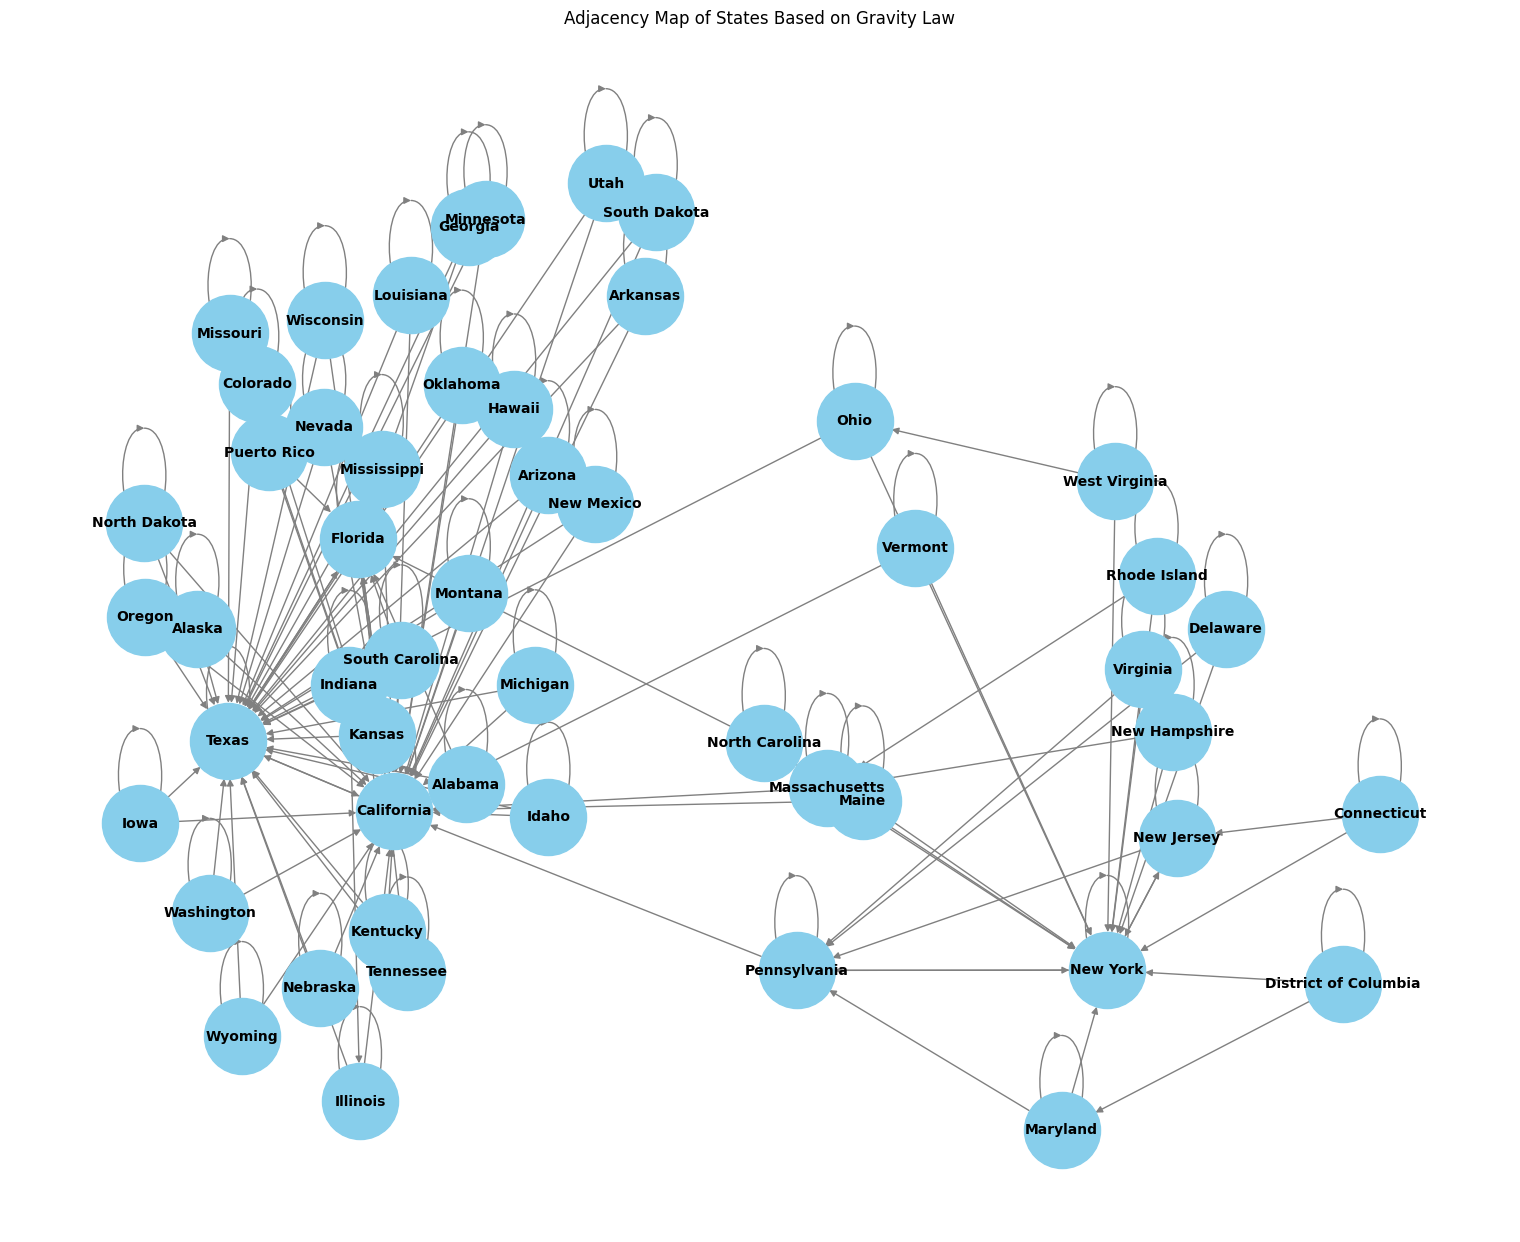

In [ ]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for state in adj_map.keys():
    G.add_node(state)

# Add edges
for state, neighbors in adj_map.items():
    for neighbor in neighbors:
        G.add_edge(state, neighbor)

# Plot the graph
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=RANDOM_SEED)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Adjacency Map of States Based on Gravity Law')
plt.show()

In [ ]:
# Define feature names
dynamic_feature_names = ['confirmed', 'deaths', 'recovered', 'active', 'hospitalization', 'new_cases']
static_feature_names = ['population', 'density', 'lat', 'lng']

# Sort data by state and date to ensure chronological order
raw_data = raw_data.sort_values(['state', 'date_today']).reset_index(drop=True)

# Display the sorted data
print("Data Sample with Selected Features:")
display(raw_data[['state', 'date_today'] + dynamic_feature_names + static_feature_names].head())


Data Sample with Selected Features:


,state,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases,population,density,lat,lng
0,Alabama,2020-05-03,7977,290,0.0,7687.0,12.0,277,4864630,139.010903,32.884042,-86.8198
1,Alabama,2020-05-04,8203,298,0.0,7905.0,29.0,226,4864630,139.010903,32.884042,-86.8198
2,Alabama,2020-05-05,8520,315,391.0,198.0,43.0,317,4864630,139.010903,32.884042,-86.8198
3,Alabama,2020-05-06,8769,343,405.0,192.0,51.0,249,4864630,139.010903,32.884042,-86.8198
4,Alabama,2020-05-07,9115,369,409.0,215.0,20.0,346,4864630,139.010903,32.884042,-86.8198


In [ ]:
# Initialize scalers
dynamic_scaler = MinMaxScaler()
hospitalization_scaler = MinMaxScaler()  # Separate scaler for the target
static_scaler = MinMaxScaler()

# Fit and transform dynamic features (excluding the target 'hospitalization')
dynamic_features = ['confirmed', 'deaths', 'recovered', 'active', 'new_cases']
raw_data[dynamic_features] = dynamic_scaler.fit_transform(raw_data[dynamic_features])

# Fit and transform the target 'hospitalization' separately
raw_data['hospitalization'] = hospitalization_scaler.fit_transform(raw_data[['hospitalization']])

# Fit and transform static features
raw_data[static_feature_names] = static_scaler.fit_transform(raw_data[static_feature_names])

print("Data after normalization:")
display(raw_data[['state', 'date_today'] + dynamic_feature_names + static_feature_names].head())


Data after normalization:


,state,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases,population,density,lat,lng
0,Alabama,2020-05-03,0.005933,0.008201,0.000000,0.014152,0.000752,0.008764,0.111067,0.025381,0.336753,0.774807
1,Alabama,2020-05-04,0.006110,0.008433,0.000000,0.014553,0.001818,0.007151,0.111067,0.025381,0.336753,0.774807
2,Alabama,2020-05-05,0.006357,0.008926,0.000400,0.000365,0.002695,0.010030,0.111067,0.025381,0.336753,0.774807
3,Alabama,2020-05-06,0.006551,0.009737,0.000415,0.000353,0.003197,0.007879,0.111067,0.025381,0.336753,0.774807
4,Alabama,2020-05-07,0.006821,0.010491,0.000419,0.000396,0.001254,0.010948,0.111067,0.025381,0.336753,0.774807


In [ ]:
def generate_series(data, window_size=35, pred_size=1):
    """
    Generates time-series sequences for modeling.
    
    Args:
        data (pd.DataFrame): The preprocessed data.
        window_size (int): Number of past days to consider.
        pred_size (int): Number of future days to predict (set to 1 for single-step prediction).
    
    Returns:
        Tuple of (X_dynamic, y, state_indices) where:
            X_dynamic: [num_samples, window_size, num_dynamic_features]
            y: [num_samples]
            state_indices: [num_samples]
    """
    X_dynamic = []
    y = []
    state_indices = []
    states = data['state'].unique()
    state_to_index = {state: idx for idx, state in enumerate(states)}
    
    for state in states:
        state_data = data[data['state'] == state].reset_index(drop=True)
        total_days = len(state_data)
        for i in range(total_days - window_size - pred_size + 1):
            X_dynamic.append(state_data.loc[i:i+window_size-1, dynamic_feature_names + ['hospitalization']].values)
            y.append(state_data.loc[i+window_size, 'hospitalization'])
            state_indices.append(state_to_index[state])
    
    X_dynamic = np.array(X_dynamic)  # [num_samples, window_size, num_dynamic_features + 1]
    y = np.array(y)  # [num_samples]
    state_indices = np.array(state_indices)  # [num_samples]
    return X_dynamic, y, state_indices

# Generate sequences with pred_size=1 for single-step prediction
window_size = 35
pred_size = 1
X_dynamic, y, state_indices = generate_series(raw_data, window_size=window_size, pred_size=pred_size)

print(f"Generated Sequences - X_dynamic shape: {X_dynamic.shape}, y shape: {y.shape}")


Generated Sequences - X_dynamic shape: (9256, 35, 7), y shape: (9256,)


In [ ]:
# Prepare static features for each state
states = raw_data['state'].unique()
state_static_features = raw_data.groupby('state').first()[static_feature_names].loc[states].values  # [num_states, num_static_features]

print(f"State Static Features Shape: {state_static_features.shape}")
display(pd.DataFrame(state_static_features, index=states, columns=static_feature_names).head())


State Static Features Shape: (52, 4)


,population,density,lat,lng
Alabama,0.111067,0.025381,0.336753,0.774807
Alaska,0.004043,0.014413,1.000000,0.043041
Arizona,0.165132,0.092061,0.355697,0.502464
Arkansas,0.062461,0.012723,0.388628,0.713668
California,1.000000,0.266810,0.418399,0.410643


In [ ]:
def temporal_split(X_dynamic, y, state_indices, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    """
    Splits the data into training, validation, and test sets based on temporal ordering.
    
    Args:
        X_dynamic (np.ndarray): Input features.
        y (np.ndarray): Targets.
        state_indices (np.ndarray): Indices mapping samples to states.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.
    
    Returns:
        Tuple: (train_X, val_X, test_X, train_y, val_y, test_y, train_states, val_states, test_states)
    """
    total_samples = X_dynamic.shape[0]
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)
    
    train_X = X_dynamic[:train_end]
    val_X = X_dynamic[train_end:val_end]
    test_X = X_dynamic[val_end:]
    
    train_y = y[:train_end]
    val_y = y[train_end:val_end]
    test_y = y[val_end:]
    
    train_states = state_indices[:train_end]
    val_states = state_indices[train_end:val_end]
    test_states = state_indices[val_end:]
    
    return train_X, val_X, test_X, train_y, val_y, test_y, train_states, val_states, test_states

# Split the data
train_X, val_X, test_X, train_y, val_y, test_y, train_states, val_states, test_states = temporal_split(
    X_dynamic, y, state_indices, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2
)

print(f"Training Set: X={train_X.shape}, y={train_y.shape}")
print(f"Validation Set: X={val_X.shape}, y={val_y.shape}")
print(f"Test Set: X={test_X.shape}, y={test_y.shape}")


Training Set: X=(5553, 35, 7), y=(5553,)
Validation Set: X=(1851, 35, 7), y=(1851,)
Test Set: X=(1852, 35, 7), y=(1852,)


In [ ]:
class HOIST_with_static(nn.Module):
    def __init__(self, dynamic_dims, static_dim, rnn_dim, device):
        """
        Initializes the HOIST_with_static model.
        
        Args:
            dynamic_dims (int): Number of dynamic features per time step.
            static_dim (int): Number of static features.
            rnn_dim (int): Number of hidden units in the LSTM.
            device (torch.device): Device to run the model on.
        """
        super(HOIST_with_static, self).__init__()
        self.dynamic_dims = dynamic_dims
        self.static_dim = static_dim
        self.device = device
        self.rnn_dim = rnn_dim

        # Define LSTM for dynamic features
        self.rnn = nn.LSTM(dynamic_dims, rnn_dim, batch_first=True, dropout=0.2)

        # Static feature transformation
        self.static_fc = nn.Sequential(
            nn.Linear(static_dim, rnn_dim),
            nn.LeakyReLU()
        )

        # Fully connected layers
        self.linear = nn.Linear(rnn_dim, rnn_dim)
        self.linear_2 = nn.Linear(rnn_dim, 1)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.2)

    def forward(self, dynamic, static, h0=None):
        """
        Forward pass of the model.
        
        Args:
            dynamic (torch.Tensor): Dynamic features [batch_size, window_size, dynamic_dims].
            static (torch.Tensor): Static features [batch_size, static_dim].
            h0 (tuple, optional): Initial hidden and cell states for LSTM.
        
        Returns:
            Tuple: (y, hn) where y is the output predictions and hn is the hidden state.
        """
        N = dynamic.size(0)  # Batch size
        T = dynamic.size(1)  # Time steps

        # Process static features
        static_embedding = self.static_fc(static)  # [N, rnn_dim]

        # Initialize hidden state if not provided
        if h0 is None:
            h0 = (torch.zeros(1, N, self.rnn_dim).to(self.device),
                  torch.zeros(1, N, self.rnn_dim).to(self.device))

        # Pass through LSTM
        h_dynamic, hn = self.rnn(dynamic, h0)  # h_dynamic: [N, T, rnn_dim]

        # Apply dropout
        h_dynamic = self.dropout(h_dynamic)

        # Add static embedding to each time step
        static_embedding = static_embedding.unsqueeze(1).expand(-1, T, -1)  # [N, T, rnn_dim]
        h = h_dynamic + static_embedding  # [N, T, rnn_dim]

        # Apply fully connected layers
        y = self.linear(h)  # [N, T, rnn_dim]
        y = F.leaky_relu(y)
        y = self.linear_2(y)  # [N, T, 1]

        return y, hn


In [ ]:
# Define dimensions
dynamic_dims = len(dynamic_feature_names)  # Number of dynamic features per time step (6)
static_dim = len(static_feature_names)    # Number of static features (4)

# Initialize the model
model = HOIST_with_static(
    dynamic_dims=dynamic_dims,
    static_dim=static_dim,
    rnn_dim=128,
    device=device
).to(device)

print("Model Architecture:")
print(model)


c:\Users\ajaoo\miniconda3\envs\icu-demand-forecasting\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Model Architecture:
HOIST_with_static(
  (rnn): LSTM(6, 128, batch_first=True, dropout=0.2)
  (static_fc): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (linear): Linear(in_features=128, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
class HOISTDataset(Dataset):
    def __init__(self, X_dynamic, y, state_indices, state_static_features):
        """
        Custom Dataset for the HOIST model.
        
        Args:
            X_dynamic (np.ndarray): Input dynamic features [num_samples, window_size, dynamic_dims].
            y (np.ndarray): Targets [num_samples].
            state_indices (np.ndarray): Indices mapping samples to states [num_samples].
            state_static_features (np.ndarray): Static features per state [num_states, static_dim].
        """
        self.X_dynamic = torch.tensor(X_dynamic, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.state_indices = torch.tensor(state_indices, dtype=torch.long)
        self.state_static_features = torch.tensor(state_static_features, dtype=torch.float32)
        
    def __len__(self):
        return self.X_dynamic.shape[0]
    
    def __getitem__(self, idx):
        state_idx = self.state_indices[idx]
        static_feat = self.state_static_features[state_idx]
        return {
            'X_dynamic': self.X_dynamic[idx],    # [window_size, dynamic_dims]
            'y': self.y[idx],                    # [1]
            'static_feat': static_feat           # [static_dim]
        }


In [ ]:
# Create Dataset instances
train_dataset = HOISTDataset(train_X, train_y, train_states, state_static_features)
val_dataset = HOISTDataset(val_X, val_y, val_states, state_static_features)
test_dataset = HOISTDataset(test_X, test_y, test_states, state_static_features)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print("DataLoaders are set up.")


DataLoaders are set up.


In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience = 10
counter = 0


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Ensure reproducibility
RANDOM_SEED = 123
def seed_everything(seed=RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [ ]:
def gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5):
    """
    Calculate the gravity law-based commute distance between two locations.
    """
    # Calculate Euclidean distance between two points
    distance = math.sqrt((lat1 - lat2)**2 + (lng1 - lng2)**2)
    # Apply gravity law formula
    gravity_dist = (pop1 * pop2) / (distance ** r + 1e-5)  # Added epsilon to avoid division by zero
    return gravity_dist


In [ ]:
# Load COVID-19 data
raw_data = pickle.load(open('./data/state_covid_data.pickle', 'rb'))

# Display the first few rows
print("COVID-19 Data Sample:")
display(raw_data.head())


COVID-19 Data Sample:


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,7977,290,0.0,7687.0,12.0,277
0,Alabama,32.3182,-86.9023,1.0,2020-05-04,8203,298,0.0,7905.0,29.0,226
0,Alabama,32.3182,-86.9023,1.0,2020-05-05,8520,315,391.0,198.0,43.0,317
0,Alabama,32.3182,-86.9023,1.0,2020-05-06,8769,343,405.0,192.0,51.0,249
0,Alabama,32.3182,-86.9023,1.0,2020-05-07,9115,369,409.0,215.0,20.0,346


In [ ]:
# Load population data
pop_data = pd.read_csv('./uszips.csv')

# Aggregate population data by state
pop_data = pop_data.groupby('state_name').agg({
    'population': 'sum',
    'density': 'mean',
    'lat': 'mean',
    'lng': 'mean'
}).reset_index()

# Merge COVID-19 data with population data
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')

# Display the merged data sample
print("Merged Data Sample:")
display(raw_data.head())

Merged Data Sample:


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases,state_name,population,density,lat,lng
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,7977,290,0.0,7687.0,12.0,277,Alabama,4864630,139.010903,32.884042,-86.8198
1,Alabama,32.3182,-86.9023,1.0,2020-05-04,8203,298,0.0,7905.0,29.0,226,Alabama,4864630,139.010903,32.884042,-86.8198
2,Alabama,32.3182,-86.9023,1.0,2020-05-05,8520,315,391.0,198.0,43.0,317,Alabama,4864630,139.010903,32.884042,-86.8198
3,Alabama,32.3182,-86.9023,1.0,2020-05-06,8769,343,405.0,192.0,51.0,249,Alabama,4864630,139.010903,32.884042,-86.8198
4,Alabama,32.3182,-86.9023,1.0,2020-05-07,9115,369,409.0,215.0,20.0,346,Alabama,4864630,139.010903,32.884042,-86.8198


In [ ]:
# Generate location similarity based on gravity law
loc_list = raw_data['state'].unique()
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    # Extract features for each_loc
    loc_data = raw_data[raw_data['state'] == each_loc].iloc[0]
    lat1 = loc_data['lat']
    lng1 = loc_data['lng']
    pop1 = loc_data['population']
    
    for each_loc2 in loc_list:
        # Extract features for each_loc2
        loc2_data = raw_data[raw_data['state'] == each_loc2].iloc[0]
        lat2 = loc2_data['lat']
        lng2 = loc2_data['lng']
        pop2 = loc2_data['population']
        
        # Calculate gravity-based commute distance
        gravity_dist = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)
        loc_dist_map[each_loc][each_loc2] = gravity_dist

print("Location Similarity Map Generated.")


Location Similarity Map Generated.


In [ ]:
# Define distance threshold
dist_threshold = 18  # Adjust based on data distribution

# Sort each state's neighbors based on similarity scores in descending order
for each_loc in loc_dist_map:
    # Sort neighbors by similarity score (descending)
    sorted_neighbors = sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)
    loc_dist_map[each_loc] = sorted_neighbors

# Create adjacency map: for each state, select top neighbors based on threshold
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, (each_loc2, score) in enumerate(loc_dist_map[each_loc]):
        if score > dist_threshold:
            if i < 3:  # Select top 3 neighbors above threshold
                adj_map[each_loc].append(each_loc2)
        else:
            if i < 1:  # Select top 1 neighbor below threshold
                adj_map[each_loc].append(each_loc2)
            else:
                break  # Stop if score is below threshold and limit reached

# Display adjacency map
print("Adjacency Map:")
for state, neighbors in adj_map.items():
    print(f"{state}: {neighbors}")


Adjacency Map:
Alabama: ['Alabama', 'Texas', 'Florida']
Alaska: ['Alaska', 'California', 'Texas']
Arizona: ['Arizona', 'California', 'Texas']
Arkansas: ['Arkansas', 'Texas', 'California']
California: ['California', 'Texas', 'Florida']
Colorado: ['Colorado', 'California', 'Texas']
Connecticut: ['Connecticut', 'New York', 'New Jersey']
Delaware: ['Delaware', 'New York', 'Pennsylvania']
District of Columbia: ['District of Columbia', 'Maryland', 'New York']
Florida: ['Florida', 'Texas', 'California']
Georgia: ['Georgia', 'Florida', 'Texas']
Hawaii: ['Hawaii', 'California', 'Texas']
Idaho: ['Idaho', 'California', 'Texas']
Illinois: ['Illinois', 'Texas', 'California']
Indiana: ['Indiana', 'Illinois', 'Texas']
Iowa: ['Iowa', 'Texas', 'California']
Kansas: ['Kansas', 'Texas', 'California']
Kentucky: ['Kentucky', 'Texas', 'California']
Louisiana: ['Louisiana', 'Texas', 'California']
Maine: ['Maine', 'New York', 'California']
Maryland: ['Maryland', 'New York', 'Pennsylvania']
Massachusetts: ['Ma

In [ ]:
# Initialize adjacency matrix
num_states = len(loc_list)
adj_matrix = np.zeros((num_states, num_states), dtype=np.float32)

# Populate adjacency matrix based on adj_map
state_to_index = {state: idx for idx, state in enumerate(loc_list)}
for each_loc in adj_map:
    i = state_to_index[each_loc]
    for each_loc2 in adj_map[each_loc]:
        j = state_to_index[each_loc2]
        adj_matrix[i][j] = 1  # Binary adjacency; set to 1 if connected

# Add self-loops to the adjacency matrix
adj_matrix += np.eye(num_states, dtype=np.float32)

# Normalize adjacency matrix
adj_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)

# Convert adjacency matrix to tensor
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32).to(device)

print(f"Adjacency Matrix Shape: {adj_matrix.shape}")


Adjacency Matrix Shape: torch.Size([52, 52])


In [ ]:
# Select relevant columns
dynamic_feature_names = ['confirmed', 'deaths', 'recovered', 'active', 'new_cases']  # Exclude 'hospitalization' for now
target_feature_name = 'hospitalization'
static_feature_names = ['population', 'density', 'lat', 'lng']

# Sort data by state and date
raw_data = raw_data.sort_values(['state', 'date_today']).reset_index(drop=True)

# Display the data
print("Data Sample with Selected Features:")
display(raw_data[['state', 'date_today'] + dynamic_feature_names + [target_feature_name] + static_feature_names].head())


Data Sample with Selected Features:


,state,date_today,confirmed,deaths,recovered,active,new_cases,hospitalization,population,density,lat,lng
0,Alabama,2020-05-03,7977,290,0.0,7687.0,277,12.0,4864630,139.010903,32.884042,-86.8198
1,Alabama,2020-05-04,8203,298,0.0,7905.0,226,29.0,4864630,139.010903,32.884042,-86.8198
2,Alabama,2020-05-05,8520,315,391.0,198.0,317,43.0,4864630,139.010903,32.884042,-86.8198
3,Alabama,2020-05-06,8769,343,405.0,192.0,249,51.0,4864630,139.010903,32.884042,-86.8198
4,Alabama,2020-05-07,9115,369,409.0,215.0,346,20.0,4864630,139.010903,32.884042,-86.8198


In [ ]:
# Initialize scalers
dynamic_scaler = MinMaxScaler()
static_scaler = MinMaxScaler()
hospitalization_scaler = MinMaxScaler()

# Fit scalers on the entire dataset
raw_data[dynamic_feature_names] = dynamic_scaler.fit_transform(raw_data[dynamic_feature_names])
raw_data[static_feature_names] = static_scaler.fit_transform(raw_data[static_feature_names])

# Fit the hospitalization scaler
raw_data[[target_feature_name]] = hospitalization_scaler.fit_transform(raw_data[[target_feature_name]])

print("Data after normalization:")
display(raw_data[['state', 'date_today'] + dynamic_feature_names + [target_feature_name] + static_feature_names].head())


Data after normalization:


,state,date_today,confirmed,deaths,recovered,active,new_cases,hospitalization,population,density,lat,lng
0,Alabama,2020-05-03,0.005933,0.008201,0.000000,0.014152,0.008764,0.000752,0.111067,0.025381,0.336753,0.774807
1,Alabama,2020-05-04,0.006110,0.008433,0.000000,0.014553,0.007151,0.001818,0.111067,0.025381,0.336753,0.774807
2,Alabama,2020-05-05,0.006357,0.008926,0.000400,0.000365,0.010030,0.002695,0.111067,0.025381,0.336753,0.774807
3,Alabama,2020-05-06,0.006551,0.009737,0.000415,0.000353,0.007879,0.003197,0.111067,0.025381,0.336753,0.774807
4,Alabama,2020-05-07,0.006821,0.010491,0.000419,0.000396,0.010948,0.001254,0.111067,0.025381,0.336753,0.774807


In [ ]:
def generate_series(data, window_size=35, pred_size=1):
    """
    Generates time-series sequences for modeling.

    Args:
        data (pd.DataFrame): The preprocessed data.
        window_size (int): Number of past days to consider.
        pred_size (int): Number of future days to predict.

    Returns:
        X_dynamic (np.ndarray): Dynamic features [num_samples, window_size, num_dynamic_features].
        y (np.ndarray): Targets [num_samples, pred_size].
        state_indices (np.ndarray): Indices mapping each sample to a state.
    """
    X_dynamic = []
    y = []
    state_indices = []
    states = data['state'].unique()
    state_to_index = {state: idx for idx, state in enumerate(states)}
    
    for state in states:
        state_data = data[data['state'] == state].reset_index(drop=True)
        total_days = len(state_data)
        for i in range(total_days - window_size - pred_size + 1):
            X_dynamic.append(state_data.loc[i:i+window_size-1, dynamic_feature_names].values)
            y.append(state_data.loc[i+window_size:i+window_size+pred_size-1, target_feature_name].values)
            state_indices.append(state_to_index[state])
    
    X_dynamic = np.array(X_dynamic)  # [num_samples, window_size, num_dynamic_features]
    y = np.array(y)  # [num_samples, pred_size]
    state_indices = np.array(state_indices)  # [num_samples]
    return X_dynamic, y, state_indices

# Generate sequences
window_size = 35
pred_size = 1  # Single-step prediction
X_dynamic, y, state_indices = generate_series(raw_data, window_size=window_size, pred_size=pred_size)

print(f"Generated Sequences - X_dynamic shape: {X_dynamic.shape}, y shape: {y.shape}")


Generated Sequences - X_dynamic shape: (9256, 35, 5), y shape: (9256, 1)


In [ ]:
# Prepare static features for each state
states = raw_data['state'].unique()
state_static_features = raw_data.groupby('state').first()[static_feature_names].loc[states].values  # [num_states, num_static_features]

print(f"State Static Features Shape: {state_static_features.shape}")


State Static Features Shape: (52, 4)


In [ ]:
def temporal_split(X_dynamic, y, state_indices, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    """
    Splits the data into training, validation, and test sets based on temporal ordering.

    Args:
        X_dynamic (np.ndarray): Dynamic features.
        y (np.ndarray): Targets.
        state_indices (np.ndarray): Indices mapping each sample to a state.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.

    Returns:
        Tuple: Training, validation, and test sets for X, y, and state indices.
    """
    total_samples = X_dynamic.shape[0]
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)
    
    train_X = X_dynamic[:train_end]
    val_X = X_dynamic[train_end:val_end]
    test_X = X_dynamic[val_end:]
    
    train_y = y[:train_end]
    val_y = y[train_end:val_end]
    test_y = y[val_end:]
    
    train_states = state_indices[:train_end]
    val_states = state_indices[train_end:val_end]
    test_states = state_indices[val_end:]
    
    return train_X, val_X, test_X, train_y, val_y, test_y, train_states, val_states, test_states

# Split the data
train_X, val_X, test_X, train_y, val_y, test_y, train_states, val_states, test_states = temporal_split(
    X_dynamic, y, state_indices, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2
)

print(f"Training Set: X={train_X.shape}, y={train_y.shape}")
print(f"Validation Set: X={val_X.shape}, y={val_y.shape}")
print(f"Test Set: X={test_X.shape}, y={test_y.shape}")


Training Set: X=(5553, 35, 5), y=(5553, 1)
Validation Set: X=(1851, 35, 5), y=(1851, 1)
Test Set: X=(1852, 35, 5), y=(1852, 1)


In [ ]:
class HOIST_with_static(nn.Module):
    def __init__(self, dynamic_dims, static_dim, rnn_dim, device):
        """
        HOIST model with static features.

        Args:
            dynamic_dims (int): Number of dynamic features per time step.
            static_dim (int): Number of static features.
            rnn_dim (int): Number of hidden units in the RNN layer.
            device (torch.device): Device to run the model on.
        """
        super(HOIST_with_static, self).__init__()
        self.dynamic_dims = dynamic_dims
        self.static_dim = static_dim  # Total number of static features
        self.device = device
        self.rnn_dim = rnn_dim

        # Define LSTM for dynamic features
        self.rnn = nn.LSTM(dynamic_dims, rnn_dim, batch_first=True)

        # Static feature transformation
        self.static_fc = nn.Sequential(
            nn.Linear(static_dim, rnn_dim),
            nn.LeakyReLU()
        )

        # Fully connected layers
        self.linear = nn.Linear(rnn_dim, rnn_dim)
        self.linear_2 = nn.Linear(rnn_dim, 1)

    def forward(self, dynamic, static, h0=None):
        """
        Forward pass of the model.

        Args:
            dynamic (torch.Tensor): Dynamic features [batch_size, window_size, dynamic_dims].
            static (torch.Tensor): Static features [batch_size, static_dim].
            h0 (tuple, optional): Initial hidden state for LSTM.

        Returns:
            y (torch.Tensor): Output predictions [batch_size, window_size, 1].
            hn (tuple): Final hidden state from LSTM.
        """
        N = dynamic.size(0)  # Batch size
        T = dynamic.size(1)  # Time steps

        # Process static features
        static_embedding = self.static_fc(static)  # [N, rnn_dim]

        # Initialize hidden state if not provided
        if h0 is None:
            h0 = (torch.zeros(1, N, self.rnn_dim).to(self.device),
                  torch.zeros(1, N, self.rnn_dim).to(self.device))

        # Pass through LSTM
        h_dynamic, hn = self.rnn(dynamic, h0)  # h_dynamic: [N, T, rnn_dim]

        # Add static embedding to each time step
        static_embedding = static_embedding.unsqueeze(1).expand(-1, T, -1)  # [N, T, rnn_dim]
        h = h_dynamic + static_embedding  # [N, T, rnn_dim]

        # Final transformations
        y = self.linear(h)  # [N, T, rnn_dim]
        y = self.linear_2(F.leaky_relu(y))  # [N, T, 1]

        return y, hn


In [ ]:
# Define dimensions
dynamic_dims = len(dynamic_feature_names)  # Number of dynamic features per time step
static_dim = len(static_feature_names)  # Number of static features

# Initialize the model
model = HOIST_with_static(
    dynamic_dims=dynamic_dims,
    static_dim=static_dim,
    rnn_dim=128,  # You can adjust this parameter
    device=device
).to(device)

print(model)


HOIST_with_static(
  (rnn): LSTM(5, 128, batch_first=True)
  (static_fc): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (linear): Linear(in_features=128, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
class HOISTDataset(Dataset):
    def __init__(self, X_dynamic, y, state_indices, state_static_features):
        """
        Custom Dataset for the HOIST model.

        Args:
            X_dynamic (np.ndarray): Dynamic features [num_samples, window_size, dynamic_dims].
            y (np.ndarray): Targets [num_samples, pred_size].
            state_indices (np.ndarray): Indices mapping each sample to a state.
            state_static_features (np.ndarray): Static features for each state [num_states, static_dim].
        """
        self.X_dynamic = torch.tensor(X_dynamic, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.state_indices = state_indices
        self.state_static_features = torch.tensor(state_static_features, dtype=torch.float32)
        
    def __len__(self):
        return self.X_dynamic.shape[0]
    
    def __getitem__(self, idx):
        state_idx = self.state_indices[idx]
        static_feat = self.state_static_features[state_idx]
        return {
            'X_dynamic': self.X_dynamic[idx],  # [window_size, dynamic_dims]
            'y': self.y[idx],  # [pred_size]
            'static_feat': static_feat,  # [static_dim]
        }


In [ ]:
# Create Dataset instances
train_dataset = HOISTDataset(train_X, train_y, train_states, state_static_features)
val_dataset = HOISTDataset(val_X, val_y, val_states, state_static_features)
test_dataset = HOISTDataset(test_X, test_y, test_states, state_static_features)

# Create DataLoaders
batch_size = 64  # Adjust based on memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print("DataLoaders are set up.")


DataLoaders are set up.


In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training parameters
num_epochs = 50  # You can adjust this
best_val_loss = float('inf')
patience = 5  # Early stopping patience
counter = 0


In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_losses = []
    
    for batch in train_loader:
        X_dynamic = batch['X_dynamic'].to(device)  # [batch_size, window_size, dynamic_dims]
        y_batch = batch['y'].to(device)  # [batch_size, pred_size]
        static_feat = batch['static_feat'].to(device)  # [batch_size, static_dim]
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(X_dynamic, static_feat)
        # outputs: [batch_size, window_size, 1]
        
        # Use the last output to predict the next time step
        preds = outputs[:, -1, 0]  # [batch_size]
        target = y_batch[:, 0]     # [batch_size]
        
        loss = criterion(preds, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            X_dynamic = batch['X_dynamic'].to(device)
            y_batch = batch['y'].to(device)
            static_feat = batch['static_feat'].to(device)
            
            outputs, _ = model(X_dynamic, static_feat)
            preds = outputs[:, -1, 0]
            target = y_batch[:, 0]
            
            loss = criterion(preds, target)
            val_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    
    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))


Epoch [1/50], Train Loss: 0.000445, Val Loss: 0.000009
Epoch [2/50], Train Loss: 0.000065, Val Loss: 0.000009
Epoch [3/50], Train Loss: 0.000062, Val Loss: 0.000023
Epoch [4/50], Train Loss: 0.000069, Val Loss: 0.000014
Epoch [5/50], Train Loss: 0.000061, Val Loss: 0.000011
Epoch [6/50], Train Loss: 0.000065, Val Loss: 0.000014
Epoch [7/50], Train Loss: 0.000061, Val Loss: 0.000013
Early stopping triggered.


<All keys matched successfully>